In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install Unidecode

     |████████████████████████████████| 245kB 5.7MB/s 


In [ ]:
train_df_path   = "/content/drive/MyDrive/CASE STUDY - 1/submission/Factorization Machine/train.tsv"
test2_df_path   = "/content/drive/MyDrive/CASE STUDY - 1/submission/Factorization Machine/test_stg2.tsv"

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import regex as re
import unidecode
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
from nltk.stem import PorterStemmer 
import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, Normalizer, LabelEncoder
from sklearn.model_selection import train_test_split
import scipy
from scipy.sparse import csr_matrix
from nltk import word_tokenize, pos_tag, ne_chunk
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow import keras
import itertools
import multiprocessing
from multiprocessing import Pool
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack
import gc
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Input, GRU, LSTM, Dense, BatchNormalization, Dropout, RNN, Flatten, GlobalAveragePooling1D, concatenate, PReLU, Concatenate
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.utils import plot_model


num_cores = multiprocessing.cpu_count()
num_cores


2

In [ ]:
train_df  = pd.read_table(train_df_path)
test_df = pd.read_table(test2_df_path)

In [ ]:
train_df = train_df[train_df['price']>0]

In [ ]:
# https://stackoverflow.com/questions/13331698/how-to-apply-a-function-to-two-columns-of-pandas-dataframe

# concat cat_1, cat_2, cat_3 
def concat_c1_c2_c3(c_1, c_2, c_3):
    return c_1 + "/" + c_2 + "/" + c_3


# filling missing cat-1, cat-2, cat-3 column from item_description and name
def miss_cat_1_2_3(x, name, desc, x_set):
    
    if x == 'nan':
        for cat in x_set:
            
            try:
                if cat in desc:
                    return cat
                elif cat in name:
                    return cat
                else:
                    return 'other'
            except:
                return 'other'
    else:
        return x
    

def miss_brand(x, name, desc, x_set):
    
    if x == 'nan':
        for cat in x_set:
            
            try:
                if cat in desc:
                    return cat
                elif cat in name:
                    return cat
                else:
                    return 'unknown'
            except:
                return 'unknown'
    else:
        return x


def fill_missing_data(df):
    
    
    df['cat_1'] = df.category_name.str.split('/').str.get(0).astype('category')
    df['cat_2'] = df.category_name.str.split('/').str.get(1).astype('category')
    df['cat_3'] = df.category_name.str.split('/').str.get(2).astype('category')
    
    cat_1_set = np.unique(df['cat_1'].astype(str))
    cat_1_set = np.delete(cat_1_set, np.argwhere(cat_1_set=='nan'))
    
    cat_2_set = np.unique(df['cat_2'].astype(str))
    cat_2_set = np.delete(cat_2_set, np.argwhere(cat_2_set=='nan'))
    
    cat_3_set = np.unique(df['cat_3'].astype(str))
    cat_3_set = np.delete(cat_3_set, np.argwhere(cat_3_set=='nan'))
    
    brand_name_set = np.unique(df['brand_name'].astype(str))
    brand_name_set = np.delete(brand_name_set, np.argwhere(brand_name_set=='nan'))
    
    df['cat_1']         = df.apply(lambda x: miss_cat_1_2_3(str(x.cat_1), str(x.name), x.item_description, cat_1_set), axis=1)
    df['cat_2']         = df.apply(lambda x: miss_cat_1_2_3(str(x.cat_2), str(x.name), x.item_description, cat_2_set), axis=1)
    df['cat_3']         = df.apply(lambda x: miss_cat_1_2_3(str(x.cat_3), str(x.name), x.item_description, cat_3_set), axis=1)
    df['brand_name']    = df.apply(lambda x: miss_brand(str(x.brand_name), str(x.name), x.item_description, brand_name_set), axis=1)
    df['category_name'] = df.apply(lambda x: concat_c1_c2_c3(str(x.cat_1), str(x.cat_2), str(x.cat_3)), axis=1)
    df['item_description'].fillna(value = "no description yet", inplace = True)
    
    return df

In [ ]:

def parallelize_dataframe(df, func):
    df_split = np.array_split(df, num_cores)
    with Pool(num_cores) as pool:
        df = pd.concat(pool.map(func, df_split))
    return df


In [ ]:
%%time
train_df = parallelize_dataframe(train_df, fill_missing_data)
train_df.isnull().any()

CPU times: user 5.19 s, sys: 2.04 s, total: 7.23 s
Wall time: 2min 43s


In [ ]:
gc.collect()

195

In [ ]:
%%time
test_df = parallelize_dataframe(test_df, fill_missing_data)
test_df.isnull().any()

CPU times: user 12.5 s, sys: 4.42 s, total: 17 s
Wall time: 6min 23s


In [ ]:
num_word_dict = {
    
    "0":"zero",
    "1":"one",
    "2":"tow",
    "3":"three",
    "4":"four",
    "5":"five",
    "6":"six",
    "7":"seven",
    "8":"eight",
    "9":"nine",
    '+':'plus'
}

def number_to_word(text):
    sentence = ''
    for letter in text:
        try:
            
            if letter.isdigit():
                sentence = sentence + ' ' + num_word_dict[letter]
            else:
                sentence = sentence + letter
        except:
            sentence = sentence + ''
            
    return sentence

def accented_to_english(text):
    return unidecode.unidecode(text)

def fill_description(text):
    if len(text) == 0:
        return "no description yet"
    else:
        return text

def fill_name(text):
    if len(text) == 0:
        return "no name"
    else:
        return text
    
def remove_stop_words(sent):
    stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]
    
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    return sent

def decontracted(phrase):
    
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    
    return phrase

def remove_line(sent):
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    
    return sent

def setmming(sent):
    ps = PorterStemmer()

def preprocess_cleaning(df):
    
    df['name'] = df['name'].apply(decontracted)
    df['name'] = df['name'].apply(remove_line)
    df['name'] = df['name'].apply(accented_to_english)
    df['name'] = df['name'].str.replace(r'[^A-Za-z0-9 ]', r' ')
    # df['name'] = df['name'].apply(number_to_word)
    df['name'] = df['name'].str.strip()
    df['name'] = df['name'].str.replace(' +', ' ')
    df['name'] = df['name'].str.lower()
    df['name'] = df['name'].apply(fill_name)
    
    df['brand_name'] = df['brand_name'].str.replace(r'[^A-Za-z0-9 ]', r' ')# remove all char except words and letters
    # df['brand_name'] = df['brand_name'].apply(number_to_word)# converting number to letter
    df['brand_name'] = df['brand_name'].str.strip()# removing leading and tailing spaces
    df['brand_name'] = df['brand_name'].str.replace(' +', ' ')# replacing double_space with single space
    df['brand_name'] = df['brand_name'].str.replace(' ', '_')# replacing space with under_score
    df['brand_name'] = df['brand_name'].str.lower()# converting to lowercase
    
    df['cat_1'] = df['cat_1'].apply(accented_to_english)
    df['cat_1'] = df['cat_1'].str.replace(r'[^A-Za-z0-9 ]', r' ')# remove all char except words and letters
    df['cat_1'] = df['cat_1'].apply(remove_line)
    df['cat_1'] = df['cat_1'].str.strip()# removing leading and tailing spaces
    df['cat_1'] = df['cat_1'].str.replace(' +', ' ')# replacing double_space with single space
    df['cat_1'] = df['cat_1'].str.replace(' ', '_')# replacing space with under_score
    df['cat_1'] = df['cat_1'].str.lower()# converting to lowercase
    
    df['cat_2'] = df['cat_2'].apply(accented_to_english)
    df['cat_2'] = df['cat_2'].str.replace(r'[^A-Za-z0-9 ]', r' ')# remove all char except words and letters
    # df['cat_2'] = df['cat_2'].apply(number_to_word)# converting number to letter
    df['cat_2'] = df['cat_2'].str.strip()# removing leading and tailing spaces
    df['cat_2'] = df['cat_2'].str.replace(' +', ' ')# replacing double_space with single space
    df['cat_2'] = df['cat_2'].str.replace(' ', '_')# replacing space with under_score
    df['cat_2'] = df['cat_2'].str.lower()# converting to lowercase
    
    df['cat_3'] = df['cat_3'].apply(accented_to_english)
    df['cat_3'] = df['cat_3'].str.replace(r'[^A-Za-z0-9 ]', r' ')# remove all char except words and letters
    #df['cat_3'] = df['cat_3'].apply(number_to_word)# converting number to letter
    df['cat_3'] = df['cat_3'].str.strip()# removing leading and tailing spaces
    df['cat_3'] = df['cat_3'].str.replace(' +', ' ')# replacing double_space with single space
    df['cat_3'] = df['cat_3'].str.replace(' ', '_')# replacing space with under_score
    df['cat_3'] = df['cat_3'].str.lower()# converting to lowercase
    
    df['category_name'] = df['cat_1'] + "_" + df['cat_2'] + "_" + df['cat_3']
    
    df['item_description'] = df['item_description'].apply(decontracted)
    df['item_description'] = df['item_description'].apply(remove_line)
    df['item_description'] = df['item_description'].apply(remove_stop_words)
    df['item_description'] = df['item_description'].apply(accented_to_english)
    df['item_description'] = df['item_description'].str.replace(r'[^a-zA-Z0-9 ]', r' ')# remove all char except words and letters
    df['item_description'] = df['item_description'].str.strip()# removing leading and tailing spaces
    df['item_description'] = df['item_description'].str.replace(' +', ' ')# replacing double_space with single space
    df['item_description'] = df['item_description'].str.lower()# converting to lowercase
    df['item_description'] = df['item_description'].apply(fill_description)
    
    return df


In [ ]:
def parallelize_dataframe(df, func):
    df_split = np.array_split(df, num_cores)
    with Pool(num_cores) as pool:
        df = pd.concat(pool.map(func, df_split))
    return df

In [ ]:
%%time
test_df = parallelize_dataframe(test_df, preprocess_cleaning)

CPU times: user 19.8 s, sys: 11.7 s, total: 31.5 s
Wall time: 9min 59s


In [ ]:
%%time
train_df = parallelize_dataframe(train_df, preprocess_cleaning)

CPU times: user 7.4 s, sys: 2.85 s, total: 10.2 s
Wall time: 4min 19s


In [ ]:
train_df['log_price'] = np.log(train_df['price'] + 1)

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/CASE STUDY - 1/data/train__cleaned.csv")
test_df = pd.read_csv("/content/drive/MyDrive/CASE STUDY - 1/data/test__cleaned.csv")

In [ ]:
train_df['log_price'] = np.log1p(train_df['price'])

In [ ]:
y = train_df['log_price']
x_train = train_df.drop(['log_price'], axis=1)

x_test  = test_df

In [ ]:
tokenizer = Tokenizer(num_words=None,
                    filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n',
                    lower=True,
                    split=' ',
                    char_level=False,
                    oov_token="<UNK>",
                    document_count=0,)
tr = train_df['name']
te = test_df['name'] 

tokenizer.fit_on_texts(tr)

vocab_name = len(tokenizer.word_index)+1

train_name = tokenizer.texts_to_sequences(tr)
test_name  = tokenizer.texts_to_sequences(te)

train_name_padded = pad_sequences(train_name, maxlen=13, padding='post')
test_name_padded = pad_sequences(test_name, maxlen=13, padding='post')


In [ ]:
tokenizer = Tokenizer(num_words=None,
                    filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n',
                    lower=True,
                    split=' ',
                    char_level=False,
                    oov_token="<UNK>",
                    document_count=0,)
tr = train_df['brand_name'] 
te = test_df['brand_name'] 

tokenizer.fit_on_texts(tr)

vocab_brand = len(tokenizer.word_index)+1

train_brand = tokenizer.texts_to_sequences(tr)
test_brand  = tokenizer.texts_to_sequences(te)

train_brand_padded = pad_sequences(train_brand, maxlen=1, padding='post')
test_brand_padded = pad_sequences(test_brand, maxlen=1, padding='post')


In [ ]:
tokenizer = Tokenizer(num_words=None,
                    filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n',
                    lower=True,
                    split=' ',
                    char_level=False,
                    oov_token="<UNK>",
                    document_count=0,)
tr = train_df['item_description'] 
te = test_df['item_description'] 

tokenizer.fit_on_texts(tr)

vocab_desc = len(tokenizer.word_index)+1

train_desc = tokenizer.texts_to_sequences(tr)
test_desc  = tokenizer.texts_to_sequences(te)

train_desc_padded = pad_sequences(train_desc, maxlen=160, padding='post')
test_desc_padded = pad_sequences(test_desc, maxlen=160, padding='post')


In [ ]:
del train_desc
del test_desc

del train_name
del test_name

del train_brand
del test_brand

In [ ]:
tokenizer = Tokenizer(num_words=None,
                    filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n',
                    lower=True,
                    split=' ',
                    char_level=False,
                    oov_token="<UNK>",
                    document_count=0,)
tr = train_df['category_name'] 
te = test_df['category_name'] 

tokenizer.fit_on_texts(tr)

vocab_cat = len(tokenizer.word_index)+1

train_cat = tokenizer.texts_to_sequences(tr)
test_cat  = tokenizer.texts_to_sequences(te)

train_cat_padded = pad_sequences(train_cat, maxlen=1, padding='post')
test_cat_padded = pad_sequences(test_cat, maxlen=1, padding='post')

In [ ]:
del train_cat
del test_cat

In [ ]:
tokenizer = Tokenizer(num_words=None,
                    filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n',
                    lower=True,
                    split=' ',
                    char_level=False,
                    oov_token="<UNK>",
                    document_count=0,)
tr = train_df['cat_1'] 
te = test_df['cat_1'] 

tokenizer.fit_on_texts(tr)

vocab_cat1 = len(tokenizer.word_index)+1

train_cat1 = tokenizer.texts_to_sequences(tr)
test_cat1  = tokenizer.texts_to_sequences(te)

train_cat1_padded = pad_sequences(train_cat1, maxlen=1, padding='post')
test_cat1_padded = pad_sequences(test_cat1, maxlen=1, padding='post')

In [ ]:
del train_cat1
del test_cat1

In [ ]:
tokenizer = Tokenizer(num_words=None,
                    filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n',
                    lower=True,
                    split=' ',
                    char_level=False,
                    oov_token="<UNK>",
                    document_count=0,)
tr = train_df['cat_2'] 
te = test_df['cat_2'] 

tokenizer.fit_on_texts(tr)

vocab_cat2 = len(tokenizer.word_index)+1

train_cat2 = tokenizer.texts_to_sequences(tr)
test_cat2  = tokenizer.texts_to_sequences(te)

train_cat2_padded = pad_sequences(train_cat2, maxlen=1, padding='post')
test_cat2_padded = pad_sequences(test_cat2, maxlen=1, padding='post')

In [ ]:
del train_cat2
del test_cat2

In [ ]:
tokenizer = Tokenizer(num_words=None,
                    filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n',
                    lower=True,
                    split=' ',
                    char_level=False,
                    oov_token="<UNK>",
                    document_count=0,)
tr = train_df['cat_3'] 
te = test_df['cat_3'] 

tokenizer.fit_on_texts(tr)

vocab_cat3 = len(tokenizer.word_index)+1

train_cat3 = tokenizer.texts_to_sequences(tr)
test_cat3  = tokenizer.texts_to_sequences(te)

train_cat3_padded = pad_sequences(train_cat3, maxlen=1, padding='post')
test_cat3_padded = pad_sequences(test_cat3, maxlen=1, padding='post')

In [ ]:
del train_cat3
del test_cat3

In [ ]:
# vect = LabelEncoder()

train_cond = train_df['item_condition_id'].to_numpy().reshape(-1, 1)
test_cond = test_df['item_condition_id'].to_numpy().reshape(-1, 1)



In [ ]:
# vect = LabelEncoder()

train_ship = train_df['shipping'].to_numpy().reshape(-1, 1)
test_ship = test_df['shipping'].to_numpy().reshape(-1, 1)

In [ ]:
from sklearn.preprocessing import StandardScaler
vect = StandardScaler()

tr = (train_df['name'].str.count("\s+")+1).fillna(0).astype(np.int64)
te = (test_df['name'].str.count("\s+")+1).fillna(0).astype(np.int64)
## vect.fit_transform(tr.to_numpy().reshape(-1, 1))
## vect.transform(te.to_numpy().reshape(-1, 1))

train_name_wc = tr.to_numpy().reshape(-1, 1)
test_name_wc = te.to_numpy().reshape(-1, 1)

In [ ]:
from sklearn.preprocessing import StandardScaler
vect = StandardScaler()

tr = (train_df['item_description'].str.count("\s+")+1).fillna(0).astype(np.int64)
te = (test_df['item_description'].str.count("\s+")+1).fillna(0).astype(np.int64)
## vect.fit_transform(tr.to_numpy().reshape(-1, 1))
## vect.transform(te.to_numpy().reshape(-1, 1))

train_desc_wc = tr.to_numpy().reshape(-1,1)
test_desc_wc = te.to_numpy().reshape(-1,1)

In [ ]:
train_df['name_brand_cat'] = train_df['name'].str.replace("no name","") + " " + train_df['brand_name'] + " " + train_df['category_name']
test_df['name_brand_cat'] = test_df['name'].str.replace("no name","") + " " + test_df['brand_name'] + " " + test_df['category_name']

In [ ]:
tokenizer = Tokenizer(num_words=None,
                    filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n',
                    lower=True,
                    split=' ',
                    char_level=False,
                    oov_token="<UNK>",
                    document_count=0,)
tr = train_df['name_brand_cat'] 
te = test_df['name_brand_cat']

tokenizer.fit_on_texts(tr)

vocab_name = len(tokenizer.word_index)+1

train_name = tokenizer.texts_to_sequences(tr)
test_name  = tokenizer.texts_to_sequences(te)

train_name_padded = pad_sequences(train_name, maxlen=10, padding='post')
test_name_padded = pad_sequences(test_name, maxlen=10, padding='post')


In [ ]:
# train_cat_padded, test_cat_padded

X_train = [train_name_padded, train_desc_padded,
           
           train_brand_padded, train_cat_padded,
           
           train_cat1_padded, train_cat2_padded, train_cat3_padded,
           
           train_ship, train_cond,
           
           ]


X_test = [test_name_padded, test_desc_padded,
          
          test_brand_padded, test_cat_padded,
          
          test_cat1_padded, test_cat2_padded, test_cat3_padded,
          
          test_ship, test_cond,]



In [ ]:
tf.keras.backend.clear_session()


name = Input(shape=(10,), name="name")
desc = Input(shape=(160,), name="desc")
brand = Input(shape=(1,), name="brand")
cat = Input(shape=(1,), name="cat")
cat1 = Input(shape=(1,), name="cat1")
cat2 = Input(shape=(1,), name="cat2")
cat3 = Input(shape=(1,), name="cat3")
ship = Input(shape=(1,), name="ship")
cond = Input(shape=(1,), name="cond")

name_embd = Embedding(input_dim=vocab_name, output_dim=35, name="name_embd") (name)
desc_embd = Embedding(input_dim=vocab_desc, output_dim=45, name="desc_embd") (desc)
brand_embd = Embedding(input_dim=vocab_brand, output_dim=10, name="brand_embd") (brand)
cat_embd = Embedding(input_dim=vocab_cat, output_dim=10, name="cat_embd") (cat)
cat1_embd = Embedding(input_dim=vocab_cat1, output_dim=10, name="cat1_embd") (cat1)
cat2_embd = Embedding(input_dim=vocab_cat2, output_dim=10, name="cat2_embd") (cat2)
cat3_embd = Embedding(input_dim=vocab_cat3, output_dim=10, name="cat3_embd") (cat3)
ship_embd = Embedding(input_dim=3, output_dim=10, name="ship_embd") (ship)
cond_embd = Embedding(input_dim=6, output_dim=10, name="cond_embd") (cond)

name_lstm = GRU(units=30, )(name_embd)
desc_lstm = GRU(units=50, )(desc_embd)

brand_flat = Flatten()(brand_embd)
cat1_flat = Flatten()(cat1_embd)
cat2_flat = Flatten()(cat2_embd)
cat3_flat = Flatten()(cat3_embd)
ship_flat = Flatten()(ship_embd)
cond_flat = Flatten()(cond_embd)

# cat_flat

concat = concatenate(inputs=[name_lstm, desc_lstm, brand_flat, cat1_flat, cat2_flat, cat3_flat, ship_flat, cond_flat,])
out = BatchNormalization() (concat)

out = Dense(units=512, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.0001)) (concat)
out = BatchNormalization() (out)

out = Dense(units=128, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.0001)) (concat)
out = BatchNormalization() (out)

out = Dense(units=64, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.0001)) (concat)
out = BatchNormalization() (out)

out = Dense(units=1, kernel_initializer='normal')(out)


model = Model([name, desc, brand,cat, cat1, cat2, cat3, ship, cond,], out)


model.summary()



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
name (InputLayer)               [(None, 10)]         0                                            
__________________________________________________________________________________________________
desc (InputLayer)               [(None, 160)]        0                                            
__________________________________________________________________________________________________
brand (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
cat1 (InputLayer)               [(None, 1)]          0                                            
______________________________________________________________________________________________

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
name (InputLayer)               [(None, 10)]         0                                            
__________________________________________________________________________________________________
desc (InputLayer)               [(None, 160)]        0                                            
__________________________________________________________________________________________________
brand (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
cat1 (InputLayer)               [(None, 1)]          0                                            
______________________________________________________________________________________________

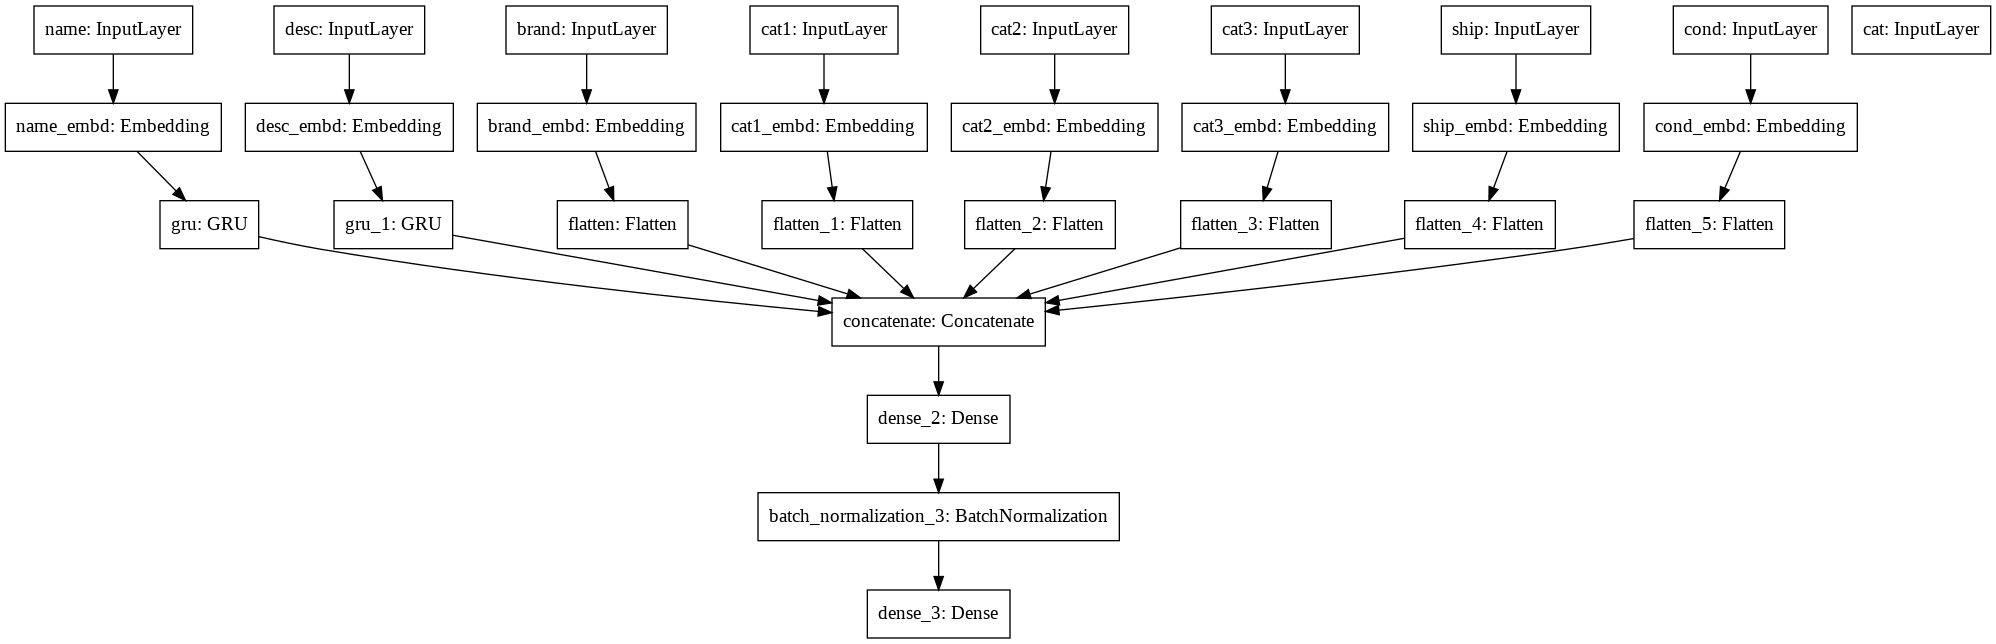

In [ ]:
plot_model(model, to_file="LSTM.png",)

In [ ]:
opt = keras.optimizers.Adam(lr=0.002)
model.compile(optimizer=opt, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
for batch in [2000, 2000, 1000, 1000, 1000, 1000]:

  model.fit(X_train, y, batch_size=batch, epochs=1,
                                    verbose=1,
                                  shuffle=True,callbacks=[])

1482/1482 [==============================] - 1533s 1s/step - loss: 0.1201 - root_mean_squared_error: 0.3444


In [ ]:
y_test_pred = model.predict(X_test)

In [ ]:
y_test_pred_anti_log = np.exp(y_test_pred) - 1

In [ ]:
y_test_pred_anti_log = y_test_pred_anti_log.reshape(1, -1)[0]
y_test_pred_anti_log

array([ 6.0256023, 11.928355 , 46.03601  , ..., 16.904366 , 19.142557 ,
       18.609331 ], dtype=float32)

In [ ]:
test_ids = test_df['test_id']

In [ ]:
submission_df = pd.DataFrame({"test_id":test_ids, "price":y_test_pred_anti_log})

In [ ]:
submission_df.to_csv("submission.csv", index=False)

In [ ]:
submission_path   = "/content/drive/MyDrive/CASE STUDY - 1/submission/LSTM Model/submission.csv"

In [ ]:
submission_df.to_csv(submission_path, index=False)

In [ ]:
from IPython.display import Image

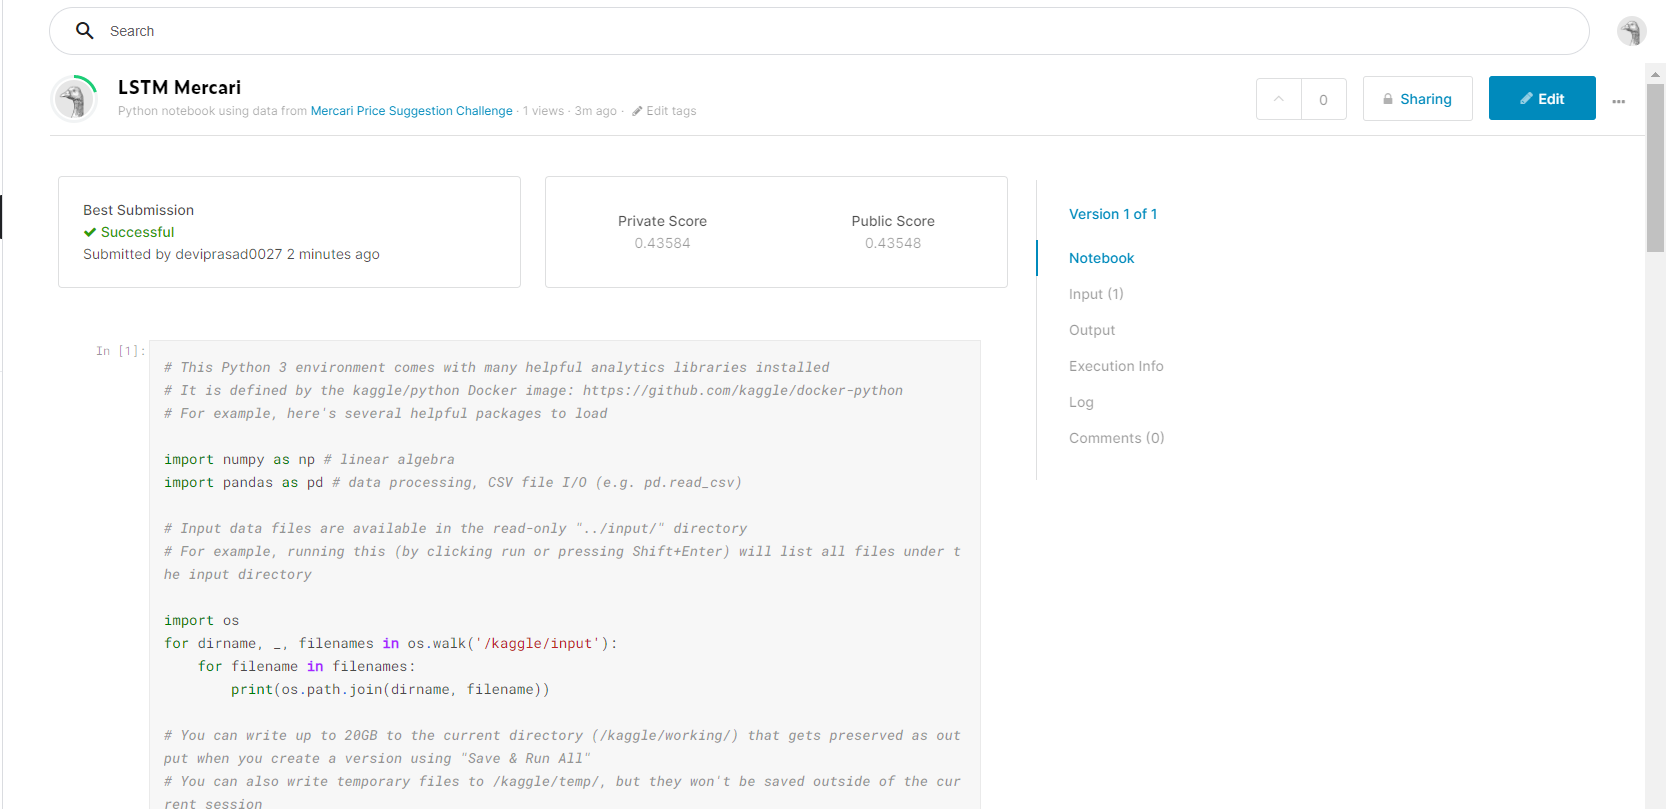

In [ ]:
Image("/content/drive/MyDrive/CASE STUDY - 1/submission/LSTM Model/Capture.PNG")